# Brain Tumor Detection Using a Convolutional Neural Network

In [13]:
print('hello')

hello


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-dataset/no/no/34 no.jpg
/kaggle/input/sample-dataset/no/no/N20.JPG
/kaggle/input/sample-dataset/no/no/N1.JPG
/kaggle/input/sample-dataset/no/no/49 no.jpg
/kaggle/input/sample-dataset/no/no/N15.jpg
/kaggle/input/sample-dataset/no/no/No18.jpg
/kaggle/input/sample-dataset/no/no/31 no.jpg
/kaggle/input/sample-dataset/no/no/no 6.jpg
/kaggle/input/sample-dataset/no/no/3 no.jpg
/kaggle/input/sample-dataset/no/no/no 5.jpeg
/kaggle/input/sample-dataset/no/no/no 1.jpg
/kaggle/input/sample-dataset/no/no/26 no.jpg
/kaggle/input/sample-dataset/no/no/N26.JPG
/kaggle/input/sample-dataset/no/no/N5.jpg
/kaggle/input/sample-dataset/no/no/6 no.jpg
/kaggle/input/sample-dataset/no/no/No21.jpg
/kaggle/input/sample-dataset/no/no/17 no.jpg
/kaggle/input/sample-dataset/no/no/No22.jpg
/kaggle/input/sample-dataset/no/no/29 no.jpg
/kaggle/input/sample-dataset/no/no/46 no.jpg
/kaggle/input/sample-dataset/no/no/32 no.jpg
/kaggle/input/sample-dataset/no/no/42 no.jpg
/kaggle/input/sample-dataset/

In [14]:
!pip install imutils

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


## Import Necessary Modules

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [4]:
def crop_brain_contour(image, plot=False):
    

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)


    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
                                                                                                                                                                                                                                                                                                        
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

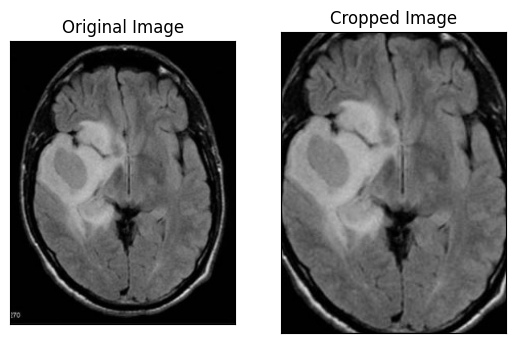

In [5]:
ex_img = cv2.imread('/kaggle/input/sample-dataset/yes/yes/Y256.JPG')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [15]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            
            image = crop_brain_contour(image, plot=False)
            
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            
            image = image / 255.
            
            X.append(image)

            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [17]:

augmented_yes = '/kaggle/input/final-data/yes' 
augmented_no = '/kaggle/input/final-data/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Plot sample images:

In [18]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

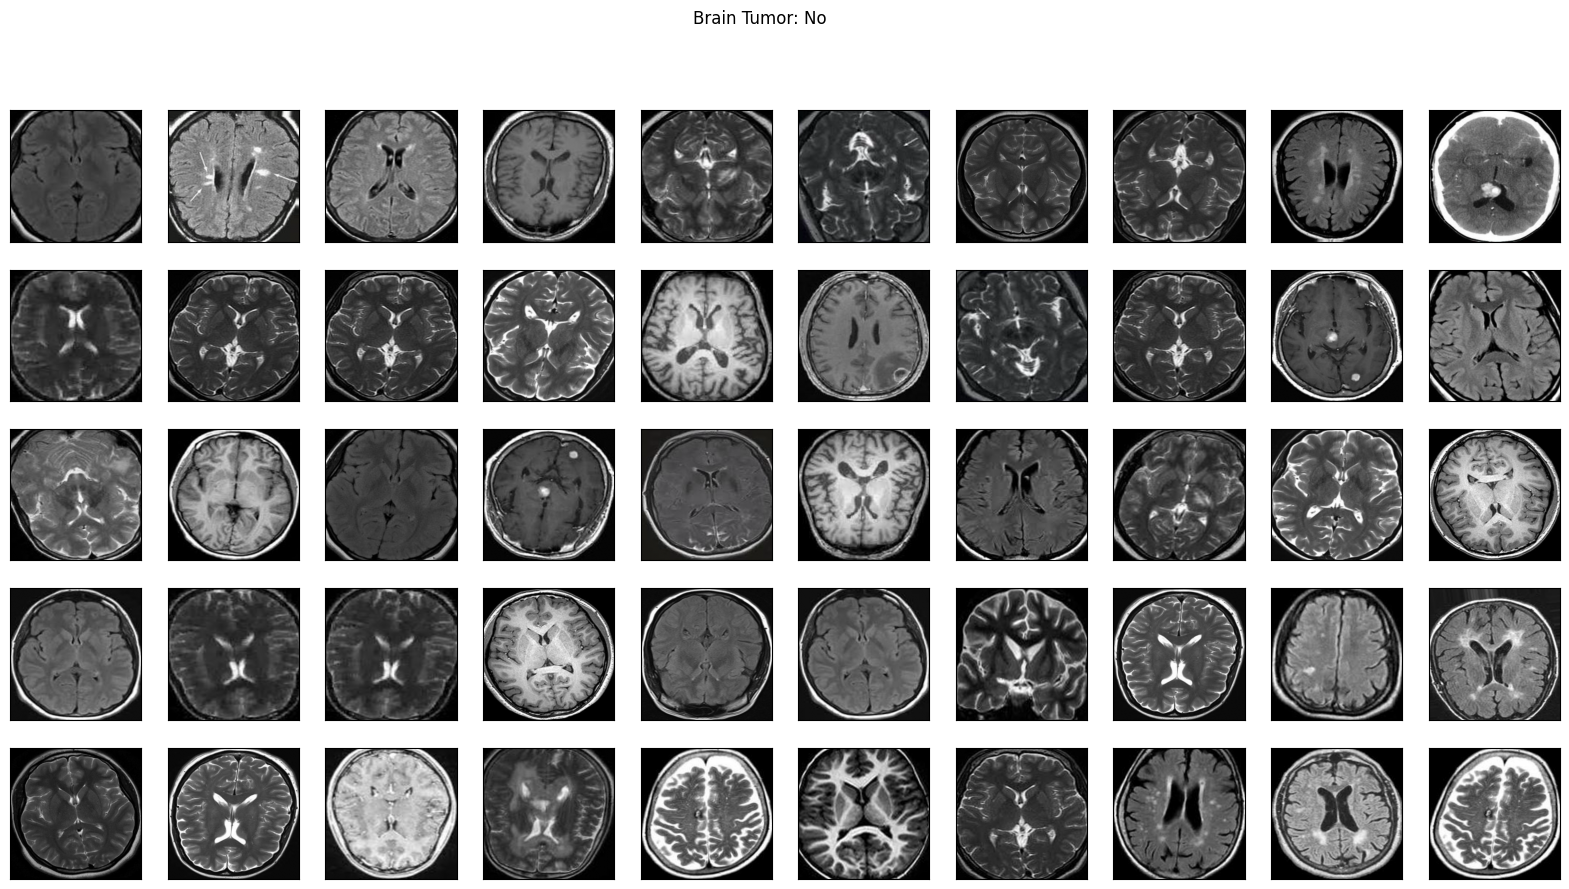

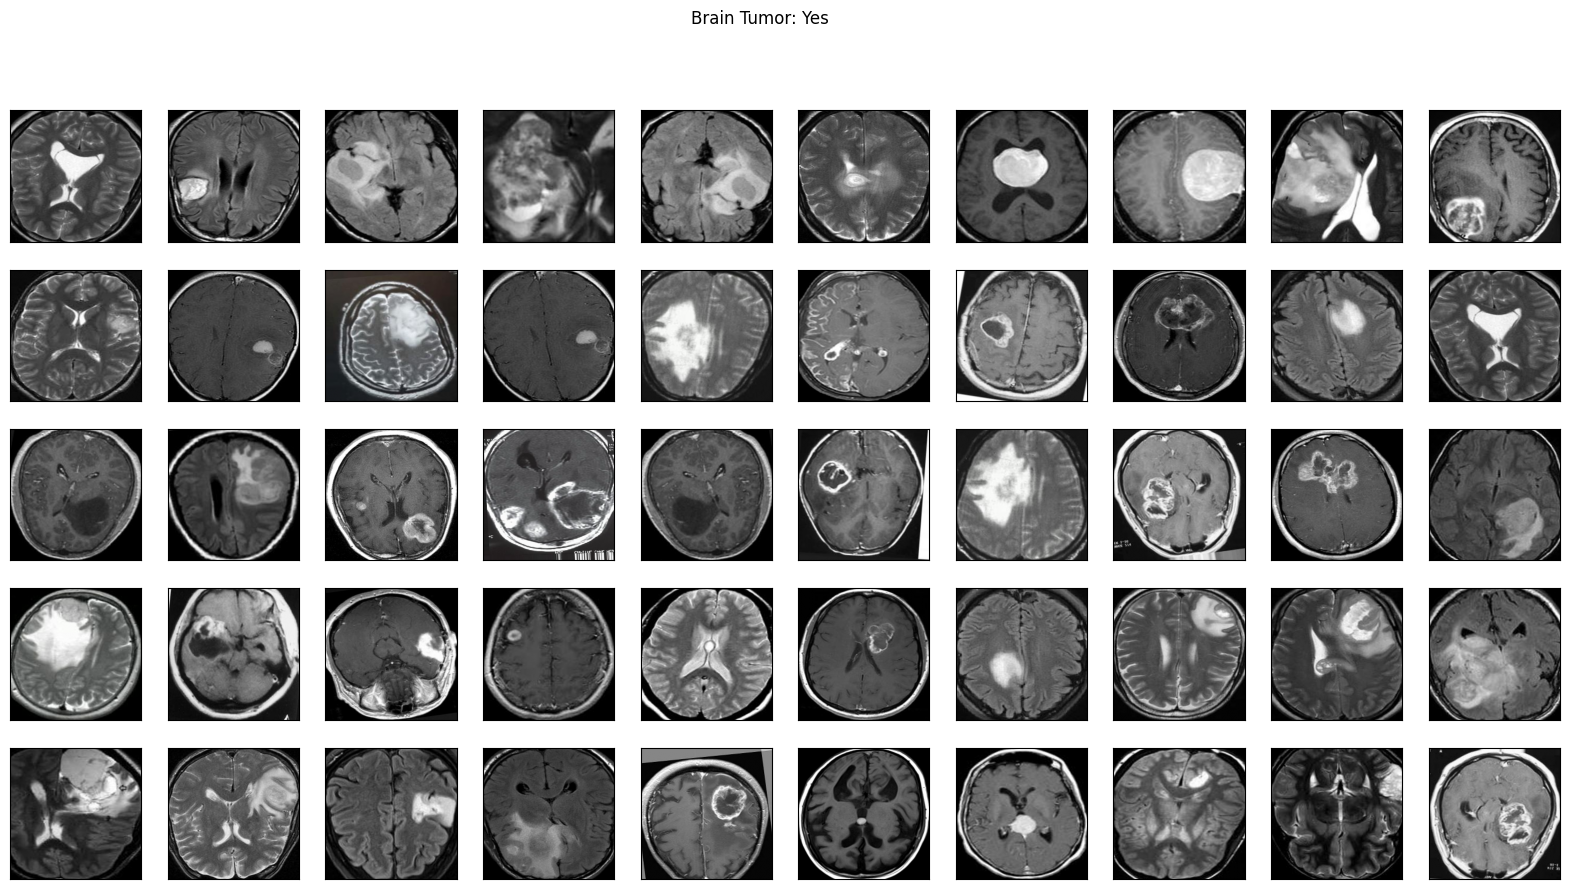

In [19]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [20]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [22]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [23]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [24]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

In [25]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [26]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [27]:
model = build_model(IMG_SHAPE)

In [28]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [31]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Train the model

In [45]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9989 - loss: 0.0333
Epoch 1: val_accuracy did not improve from 0.90323
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9988 - loss: 0.0333 - val_accuracy: 0.8065 - val_loss: 0.5281
Epoch 2/10
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9981 - loss: 0.0365
Epoch 2: val_accuracy did not improve from 0.90323
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9981 - loss: 0.0365 - val_accuracy: 0.8355 - val_loss: 0.4748
Epoch 3/10
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9966 - loss: 0.0383
Epoch 3: val_accuracy did not improve from 0.90323
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9964 - loss: 0.0385 - val_accuracy: 0.7129 - val_loss: 1.0328
Epoch 4/10
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9931 - loss: 0.0412
Epoch 4: val_accuracy did not improve from 0.90323
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9933 - loss: 0.0410 - val_accuracy: 0.9032 - val_loss:

Let's train for a few more epochs:

In [46]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0198
Epoch 1: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 0.8839 - val_loss: 0.3440
Epoch 2/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9800 - loss: 0.0629
Epoch 2: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9803 - loss: 0.0623 - val_accuracy: 0.9065 - val_loss: 0.2952
Epoch 3/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9952 - loss: 0.0345
Epoch 3: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9953 - loss: 0.0342 - val_accuracy: 0.9097 - val_loss: 0.2969
Elapsed time: 0:0:9.2


In [47]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9997 - loss: 0.0201
Epoch 1: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9996 - loss: 0.0202 - val_accuracy: 0.8774 - val_loss: 0.3843
Epoch 2/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9977 - loss: 0.0293
Epoch 2: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9978 - loss: 0.0292 - val_accuracy: 0.9161 - val_loss: 0.2956
Epoch 3/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9983 - loss: 0.0181
Epoch 3: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9984 - loss: 0.0181 - val_accuracy: 0.9065 - val_loss: 0.3058
Elapsed time: 0:0:9.3


In [48]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
44/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0118
Epoch 1: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9032 - val_loss: 0.3230
Epoch 2/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0179
Epoch 2: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 0.8774 - val_loss: 0.3751
Epoch 3/3
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9988 - loss: 0.0179
Epoch 3: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9988 - loss: 0.0179 - val_accuracy: 0.9065 - val_loss: 0.2795
Elapsed time: 0:0:9.3


In [49]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0140
Epoch 1: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9999 - loss: 0.0140 - val_accuracy: 0.9097 - val_loss: 0.2955
Epoch 2/5
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9991 - loss: 0.0225
Epoch 2: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9991 - loss: 0.0224 - val_accuracy: 0.8484 - val_loss: 0.4672
Epoch 3/5
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0116
Epoch 3: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 1.0000 - loss: 0.0116 - val_accuracy: 0.8065 - val_loss: 0.6031
Epoch 4/5
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0133
Epoch 4: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.9032 - val_loss: 0.3

In [50]:
history = model.history.history

In [38]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [51]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

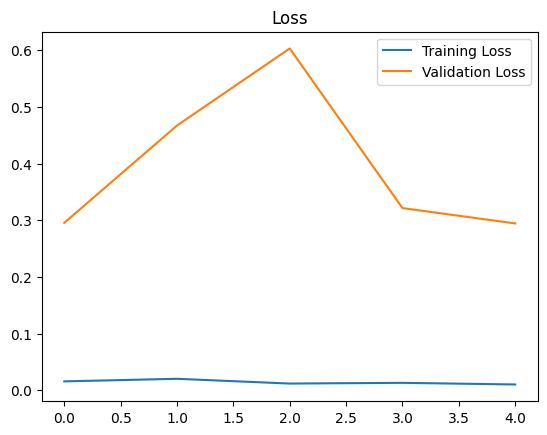

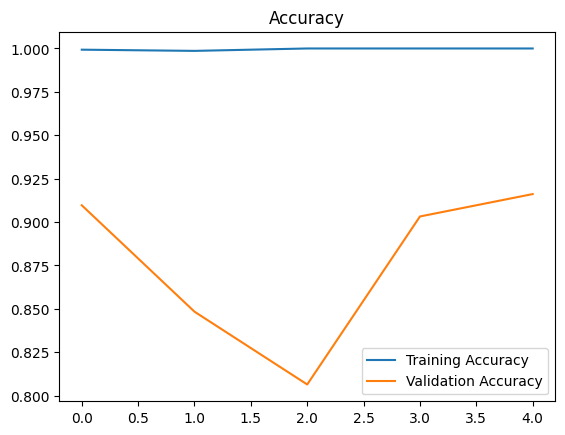

In [52]:
plot_metrics(history) 

# Results

### Load the best model

In [54]:
best_model = load_model(filepath='/kaggle/working/cnn-parameters-improvement-09-0.92.keras')

In [55]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [56]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9033 - loss: 0.3038


### Accuracy of the best model on the testing data:

In [57]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.28290289640426636
Test Accuracy = 0.9129032492637634


### F1 score for the best model on the testing data:

In [58]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [59]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9153605015673981


Let's also find the f1 score on the validation data:

In [60]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [61]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9150326797385621


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [62]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [63]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [64]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 53.01038062283737%, number of pos examples: 766
Percentage of negative examples: 46.98961937716263%, number of neg examples: 679
Validation Data:
Number of examples: 310
Percentage of positive examples: 50.0%, number of pos examples: 155
Percentage of negative examples: 50.0%, number of neg examples: 155
Testing Data:
Number of examples: 310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146


In [65]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
best_model = load_model('/kaggle/working/cnn-parameters-improvement-09-0.92.keras')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(240, 240)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Resize to match the input shape of the model
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to be between 0 and 1 (assuming the model was trained this way)
    image_resized = image_resized / 255.0
    
    # Expand dimensions to add batch size (1, img_size[0], img_size[1], 3)
    image_resized = np.expand_dims(image_resized, axis=0)
    
    return image_resized

# Function to predict tumor presence
def predict_tumor(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    if image is None:
        return
    
    # Make a prediction using the trained model
    prediction_prob = best_model.predict(image)
    
    # Interpret the result (assuming binary classification: 0 = No tumor, 1 = Tumor)
    prediction = np.argmax(prediction_prob, axis=1)[0]
    
    if prediction == 1:
        print(f"The model predicts that the image at {image_path} has a tumor.")
    else:
        print(f"The model predicts that the image at {image_path} does NOT have a tumor.")

# Example usage
image_path = '/kaggle/input/test-images/test_image/aug_1 no._0_3940.jpg'  # Define the image path
predict_tumor(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
The model predicts that the image at /kaggle/input/test-images/test_image/aug_1 no._0_3940.jpg does NOT have a tumor.


In [98]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
best_model = load_model('/kaggle/working/cnn-parameters-improvement-02-0.61.keras')

# Function to preprocess the image
def preprocess_image(image_path, img_size=(240, 240)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Resize to match the input shape of the model
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to be between 0 and 1
    image_resized = image_resized / 255.0
    
    # Expand dimensions to add batch size (1, img_size[0], img_size[1], 3)
    image_resized = np.expand_dims(image_resized, axis=0)
    
    return image_resized

# Function to predict tumor presence
def predict_tumor(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    if image is None:
        return
    
    # Make a prediction using the trained model
    prediction_prob = best_model.predict(image)
    
    # Assuming the model outputs a probability for the "tumor" class, check if it's above 0.5
    if prediction_prob[0][0] > 0.5:
        print(f"The model predicts that the image at {image_path} has a tumor. (Confidence: {prediction_prob[0][0]:.2f})")
    else:
        print(f"The model predicts that the image at {image_path} does NOT have a tumor. (Confidence: {prediction_prob[0][0]:.2f})")

# Example usage
image_path = '/kaggle/input/sample-dataset/yes/yes/Y192.JPG'  # Define the image path
predict_tumor(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
The model predicts that the image at /kaggle/input/sample-dataset/yes/yes/Y192.JPG does NOT have a tumor. (Confidence: 0.49)


In [99]:
image_path = '/kaggle/input/test-images/test_image/aug_Y3_0_4952.jpg'  # Define the image path
#ex_img = cv2.imread('/kaggle/input/test-images/test_image/aug_Y3_0_4952.jpg')
#ex_new_img = crop_brain_contour(ex_img, True)

x = preprocess_image(image_path, img_size=(240, 240))

predict_tumor(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The model predicts that the image at /kaggle/input/test-images/test_image/aug_Y3_0_4952.jpg has a tumor. (Confidence: 0.58)


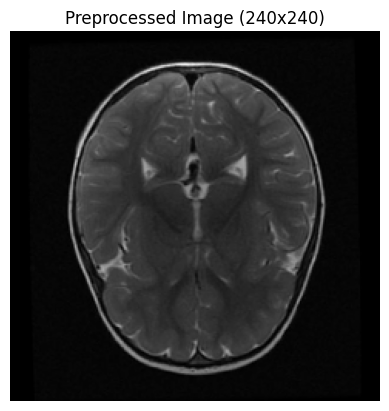

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
The model predicts that the image at /kaggle/input/test-images/test_image/aug_2 no._0_4007.jpg has a tumor. (Confidence: 1.00)


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
best_model = load_model('/kaggle/working/cnn-parameters-improvement-09-0.92.keras')

# Function to preprocess the image and show only the preprocessed version
def preprocess_image(image_path, img_size=(240, 240), plot=False):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return None

    # Resize the image
    image_resized = cv2.resize(image, img_size)
    
    # Normalize pixel values to be between 0 and 1
    image_resized = image_resized / 255.0

    # Plot the preprocessed image only
    if plot:
        plt.imshow(image_resized)
        plt.title(f"Preprocessed Image ({img_size[0]}x{img_size[1]})")
        plt.axis('off')
        plt.show()

    # Expand dimensions to add batch size (1, img_size[0], img_size[1], 3)
    image_resized = np.expand_dims(image_resized, axis=0)

    return image_resized

# Function to predict tumor presence
def predict_tumor(image_path):
    # Preprocess the image and show it
    image = preprocess_image(image_path, plot=True)
    
    if image is None:
        return
    
    # Make a prediction using the trained model
    prediction_prob = best_model.predict(image)
    
    # Assuming the model outputs a probability for the "tumor" class
    if prediction_prob[0][0] > 0.5:
        print(f"The model predicts that the image at {image_path} has a tumor. (Confidence: {prediction_prob[0][0]:.2f})")
    else:
        print(f"The model predicts that the image at {image_path} does NOT have a tumor. (Confidence: {prediction_prob[0][0]:.2f})")

# Example usage
image_path = '/kaggle/input/test-images/test_image/aug_2 no._0_4007.jpg'  # Define the image path
predict_tumor(image_path)


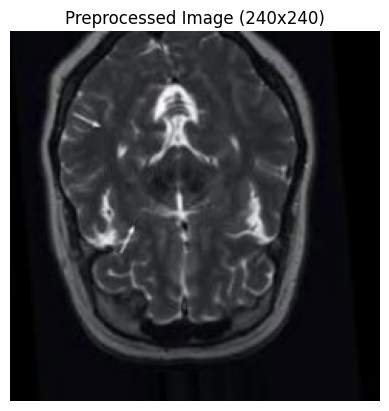

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The model predicts that the image at /kaggle/input/test-images/test_image/aug_3 no_0_2227.jpg does NOT have a tumor. (Confidence: 0.16)


In [67]:
image_path = '/kaggle/input/test-images/test_image/aug_3 no_0_2227.jpg'  # Define the image path
predict_tumor(image_path)

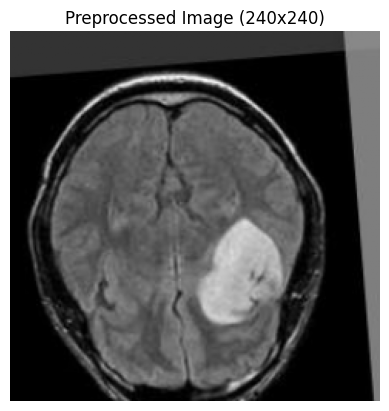

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The model predicts that the image at /kaggle/input/test-images/test_image/aug_Y4_0_2704.jpg has a tumor. (Confidence: 1.00)


In [68]:
image_path = '/kaggle/input/test-images/test_image/aug_Y4_0_2704.jpg'  # Define the image path
predict_tumor(image_path)